In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tifffile import imread, imwrite
from scipy import ndimage
from tqdm import tqdm

In [ ]:
def clear_layers(viewer):
    layers = viewer.layers
    while len(layers) > 0:
        layers.remove(layers[0])

# Generate random XY, ZX, and ZY slices from a training dataset

In [ ]:
import numpy as np
from numpy.random import randint
from tifffile import imread, imwrite
from tqdm import tqdm
import os

def get_rand_slices(im: np.ndarray, samples = 3):
    ''' 
    Returns a dictionary of random XY, XZ, and YZ slices from a 3D stack.
    Parameters: im - a 3D stack
                samples - the number of slices for each dimension to return
    Returns:    a dictionary of slices labeled with their dimension and index
    '''
    assert im.ndim == 3, 'Image must be 3D'
    d = {}
    z,y,x = im.shape
    for n in range(samples):
        randyx = randint(0,z)
        randzx = randint(0,y)
        randzy = randint(0,x)
        d[f"randyx_{randyx}_#{n}"]=im[randyx]
        d[f"randzx_{randzx}_#{n}"]=im[:,randzx]
        d[f"randzy_{randzy}_#{n}"]=im[:,:,randzy]
    return d

source = '/Volumes/bigData/wholeMount_volDist/220712_Fix_Emb_Flvw_Chn1GAP_PI_aTub647_Processed/N2V_Denoised/16bit_scaleZ_sbdl2'
dest = '/Volumes/bigData/wholeMount_volDist/220712_Fix_Emb_Flvw_Chn1GAP_PI_aTub647_Processed/N2V_Denoised/16bit_scaleZ_sbdl2_random_slices'
if not os.path.exists(dest):
    os.mkdir(dest)
names = [f for f in os.listdir(source) if f.endswith('_16bit_scaleZ_sbdl2_16bit.tif') and not f.startswith('.')]
for name in tqdm(names):
    im = imread(source +'/'+name)
    justname = name.split('.')[0]
    slices = get_rand_slices(im, samples = 3)
    for k,v in slices.items():
        imwrite(f'{dest}/{justname}_{k}.tif',v)

# Augment dataset by artificially turning xy slices into xz slices by adding 1D Gaussian Blur

#### Example of synthetic training data

In [ ]:
og_path = '/Volumes/bigData/wholeMount_volDist/CellposeTraining_V2/220710_Fix_Em_Flvw_Mix_PI_aTub647_E02-Z01_PI_16bit_randyx_164_#1.tif'
og = imread(og_path)
# a Gaussian filter with a standard deviation of 10
gauss = ndimage.gaussian_filter1d(og, 7, 0)

fig, (ax1, ax2) = plt.subplots(1, 2, dpi=200)
ax1.imshow(og, cmap='gray', vmin = 0, vmax=15000)
ax2.imshow(gauss, cmap='gray', vmin = 0, vmax=15000)

get rid of the log processed files, and existing ortho projections

In [ ]:
target_dir = '/Volumes/bigData/wholeMount_volDist/CellposeTraining_V3/new_gauss/'

# make a list of files with "log" in the name
delete_list = [f for f in os.listdir(target_dir) if 'log' in f or 'zx' in f or 'zy' in f]
# delete the files
for f in delete_list:
    os.remove(os.path.join(target_dir, f))

ims = [f for f in os.listdir(target_dir) if f.endswith('tif') and 'yx' in f and not f.startswith('.')]

Gaussian blur the images

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tifffile import imread, imwrite
from scipy import ndimage
from tqdm import tqdm

with tqdm(total = len(ims)) as pbar:
    for im in ims:
        im_path = os.path.join(target_dir, im)
        im_data = imread(im_path)
        im_data = ndimage.gaussian_filter1d(im_data, 7.5, 0)
        imwrite(im_path, im_data)
        pbar.update(1)

Rename in the images and .npy files

In [ ]:
tifs = [f for f in os.listdir(target_dir) if f.endswith('.tif') and not f.startswith('.')]
segs = [f for f in os.listdir(target_dir) if f.endswith('.npy') and not f.startswith('.')]

for f in tifs:
    base = f.split('.')[0]
    newname = base + '_gauss.tif'
    os.rename(os.path.join(target_dir, f), os.path.join(target_dir, newname))

for s in segs:
    base = s.split('_seg.npy')[0]
    newname = base + '_gauss_seg.npy'
    os.rename(os.path.join(target_dir, s), os.path.join(target_dir, newname))

# Convert .npy files to labels and save as tif files

This is necessary for training cellpose in GDrive

In [ ]:
from tifffile import imwrite
import numpy as np
from tqdm import tqdm
import shutil
import os

# dir containing ...tif and ..._seg.npy files
raw_dir = '/Volumes/bigData/wholeMount_volDist/CellposeTraining_V2' 
tifs = [f for f in os.listdir(raw_dir) if f.endswith('.tif') and not f.startswith('.')]
segs = [f for f in os.listdir(raw_dir) if f.endswith('.npy') and not f.startswith('.')]

# create save directories
base_save_dir = '/Volumes/bigData/wholeMount_volDist/CellposeTraining_V2_GD'
image_save_dir = os.path.join(base_save_dir, 'Images')
mask_save_dir = os.path.join(base_save_dir, 'Masks')
if not os.path.exists(image_save_dir):
    os.makedirs(image_save_dir)
if not os.path.exists(mask_save_dir):
    os.makedirs(mask_save_dir)

# copy all tifs to the image save dir
for f in tifs:
    shutil.copy(os.path.join(raw_dir, f), image_save_dir)

# extract the masks out of each of the seg files and save as tif to the mask save dir
with tqdm(total=len(segs)) as pbar:
    for s in segs:
        item = np.load(os.path.join(raw_dir, s), allow_pickle=True).item()
        masks = item['masks']
        save_name = s.split('_seg.npy')[0] + '.tif'
        imwrite(os.path.join(mask_save_dir, save_name), masks)
        pbar.update(1)

Convert a single npy file into masks

In [ ]:
from tifffile import imwrite
import numpy as np
import os

# dir containing ...tif and ..._seg.npy files
dir = '/Volumes/bigData/wholeMount_volDist/220712_Fix_Emb_Flvw_Chn1GAP_PI_aTub647_Processed/N2V_Denoised/16bit_scaleZ_sbdl2'
name = '220712_Fix_Emb_Flvw_Chn1GAP_PI_aTub647_Cntrl_E02-Z01_PI_16bit_scaleZ_sbdl2_16bit_seg.npy' 

# create save directories
item = np.load(os.path.join(dir, name), allow_pickle=True).item()
masks = item['masks']
save_name = name.split('_seg.npy')[0] + '_Masks_Fused.tif'
imwrite(os.path.join(dir, save_name), masks, imagej=True, metadata={'axes': 'ZYX'})

# Batch process volumes with DoG filters

In [ ]:
import os
from tqdm import tqdm
from skimage import filters
from tifffile import imread, imwrite

processing_dir = '/Volumes/bigData/wholeMount_volDist/220712_Fix_Emb_Flvw_Chn1GAP_PI_aTub647_Processed/N2V_Denoised/16bit_scaleZ'
save_dir = os.path.join(processing_dir, 'sbdl2_processed')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

im_names = [f for f in os.listdir(processing_dir) if f.endswith('.tif') and not f.startswith('.')]

with tqdm(total=len(im_names)) as pbar:
    for im_name in im_names:
        im_base = im_name.split('.')[0]
        im = imread(os.path.join(processing_dir, im_name))
        sbdl2 = filters.difference_of_gaussians(im, low_sigma=2, high_sigma=128)
        # save as 32 bit float
        imwrite(os.path.join(save_dir, f'{im_base}_sbdl2.tif'), sbdl2.astype('float32'), imagej=True, metadata={'axes': 'ZYX'})
        pbar.update(1)

# remove a label and re-save

In [ ]:
from tifffile import imread, imwrite
import numpy as np
import os

base = '/Volumes/bigData/wholeMount_volDist/220712_Fix_Emb_Flvw_Chn1GAP_PI_aTub647_Processed/N2V_Denoised/U-Net_3D/' 
name = '220624_Fix_Flvw_Emb_PI_Utr647_E02-10X-Z01_downsample_log_Crop_46-98_Target.tif' 
masks = imread(os.path.join(base, name))
base_name = name.split('.')[0]
masks[masks == 63] = 0
imwrite(os.path.join(base, base_name + '_corr.tif'), masks, imagej=True, metadata={'axes': 'ZYX'})


# Turn instance segmentation into semantic segmentation

#### Example:

In [ ]:
from tifffile import imread, imwrite
from scipy import ndimage
import os
import numpy as np
import matplotlib.pyplot as plt

dir = '/Volumes/bigData/wholeMount_volDist/U-Net_3D_Training/Target'
sem_name = '220712_Fix_Emb_Flvw_Chn1GAP_PI_aTub647_Exp_E10-Z01_PI_16bit_scaleZ_crop_40-61_crop_Target.tif' 
sem = imread(os.path.join(dir, sem_name))

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(sem[15], cmap='Set3')

# iterate through all of the labels in sem, and erode them
labels = np.unique(sem)
binary = np.zeros(sem.shape)

for label in labels:
    if label == 0:
        continue
    else:
        mask = sem == label
        mask = ndimage.binary_erosion(mask, iterations = 2)
        binary[mask] = 1

ax2.imshow(binary[15], cmap='Set3')

#### Batch processing:

In [ ]:
from tifffile import imread, imwrite
from scipy import ndimage
import os
import numpy as np
from tqdm import tqdm

base_dir = '/Volumes/bigData/wholeMount_volDist/U-Net_3D_Training' 
mask_dir = os.path.join(base_dir, 'Target')
source_dir = os.path.join(base_dir, 'Source')
mask_names = [f for f in os.listdir(mask_dir) if f.endswith('.tif') and not f.startswith('.')]

save_dir = '/Volumes/bigData/wholeMount_volDist/U-Net_3D_Training_binary_8bit_3'
mask_save_dir = os.path.join(save_dir, 'Target')
source_save_dir = os.path.join(save_dir, 'Source')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
if not os.path.exists(mask_save_dir):
    os.makedirs(mask_save_dir)
if not os.path.exists(source_save_dir):
    os.makedirs(source_save_dir)

for mask_name in tqdm(mask_names):
    sem = imread(os.path.join(mask_dir, mask_name))
    labels = np.unique(sem)
    binary = np.zeros(sem.shape)
    for label in labels:
        if label == 0:
            continue
        else:
            mask = sem == label
            mask = ndimage.binary_erosion(mask, iterations = 2)
            binary[mask] = 1
    imwrite(os.path.join(mask_save_dir, mask_name), binary[2:-2,2:-2,2:-2].astype('uint8'), imagej=True, metadata={'axes': 'ZYX'})
    mask_base = mask_name.split('Target.tif')[0]
    source_name = mask_base + 'Source.tif'
    source = imread(os.path.join(source_dir, source_name))
    imwrite(os.path.join(source_save_dir, source_name), source[2:-2,2:-2,2:-2].astype('uint16'), imagej=True, metadata={'axes': 'ZYX'})

# turn instance into multiclass semantic segmentation

In [ ]:
from tifffile import imread, imwrite
from scipy import ndimage
import os
import numpy as np
from tqdm import tqdm

# source dirs and names
base_dir = '/Volumes/bigData/wholeMount_volDist/U-Net_3D_Training' 
mask_dir = os.path.join(base_dir, 'Target')
source_dir = os.path.join(base_dir, 'Source')
mask_names = [f for f in os.listdir(mask_dir) if f.endswith('.tif') and not f.startswith('.')]

# dest dirs and names
save_dir = '/Volumes/bigData/wholeMount_volDist/U-Net_3D_Training_multiclass_8bit_1'
mask_save_dir = os.path.join(save_dir, 'Target')
source_save_dir = os.path.join(save_dir, 'Source')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
if not os.path.exists(mask_save_dir):
    os.makedirs(mask_save_dir)
if not os.path.exists(source_save_dir):
    os.makedirs(source_save_dir)

# make the changes. background pixels are set to 0, edges are 1, cytoplasm is 2
for mask_name in tqdm(mask_names):
    instance_labels = imread(os.path.join(mask_dir, mask_name))
    labels = np.unique(instance_labels)
    binary = np.zeros(instance_labels.shape)
    for label in labels:
        if label == 0:
            continue
        else:
            mask = instance_labels == label
            eroded = ndimage.binary_erosion(mask, iterations = 2)
            binary[mask] = 1
            binary[eroded] = 2
    imwrite(os.path.join(mask_save_dir, mask_name), binary[2:-2,2:-2,2:-2].astype('uint8'), imagej=True, metadata={'axes': 'ZYX'})
    mask_base = mask_name.split('Target.tif')[0]
    source_name = mask_base + 'Source.tif'
    source = imread(os.path.join(source_dir, source_name))
    imwrite(os.path.join(source_save_dir, source_name), source[2:-2,2:-2,2:-2].astype('uint16'), imagej=True, metadata={'axes': 'ZYX'})

# Convert file to 8-bit

In [ ]:
from tifffile import imread, imwrite
import os
from tqdm import tqdm

base_dir = '/Volumes/bigData/wholeMount_volDist/U-Net_3D_Training_Binary_8bit' 
mask_dir = os.path.join(base_dir, 'Target')
source_dir = os.path.join(base_dir, 'Source')
mask_names = [f for f in os.listdir(mask_dir) if f.endswith('.tif') and not f.startswith('.')]

for mask_name in tqdm(mask_names):
    mask = imread(os.path.join(mask_dir, mask_name))
    imwrite(os.path.join(mask_dir, mask_name), mask.astype('uint8'), imagej=True, metadata={'axes': 'ZYX'})
    mask_base = mask_name.split('Target.tif')[0]
    source_name = mask_base + 'Source.tif'
    source = imread(os.path.join(source_dir, source_name))
    imwrite(os.path.join(source_dir, source_name), source[1:-1].astype('uint8'), imagej=True, metadata={'axes': 'ZYX'})

# Elastic deform

In [ ]:
import os
import numpy as np
import napari
import raster_geometry as rg
import tifffile as tif
%gui qt 

In [ ]:
viewer = napari.Viewer()

In [ ]:
import elasticdeform

clear_layers(viewer)
sphere = rg.sphere(125,40)
ints = np.zeros(sphere.shape, dtype=int)
ints[sphere] = 1
print(np.unique(ints))
viewer.add_image(sphere, name='sphere', blending='additive', colormap='green')
deformed = elasticdeform.deform_random_grid(ints, sigma=0.005, points=30)
viewer.add_image(deformed, name='deformed', blending='additive', colormap='red')
print(np.unique(deformed))

In [ ]:
from skimage.draw import line_aa
from skimage.draw import line_nd
from tqdm import tqdm

clear_layers(viewer)

object_num = 500

ROI_size = 500

start_x = np.random.randint(0,ROI_size)
end_x = np.random.randint(0, ROI_size)

start_y = np.random.randint(0,ROI_size)
end_y = np.random.randint(0, ROI_size)

start_z =  np.random.randint(0, ROI_size)
end_z =  np.random.randint(0, ROI_size)

canvas_vol = np.zeros((ROI_size, ROI_size, ROI_size))

for t in tqdm(range(object_num)):
    indice = [np.random.randint(0, ROI_size) for i in range(6)]
    
    start_pt, end_pt = indice[:3], indice[3:]
    
    line_pts = line_nd(start_pt, end_pt) 

    for i in range(len(line_pts[0])):
        canvas_vol[line_pts[0][i], line_pts[1][i], line_pts[2][i]] = 1#(2**16-1)*(2/3)  

viewer.add_image(canvas_vol, name='canvas', blending='additive', colormap='magenta')
deformed = elasticdeform.deform_random_grid(canvas_vol, sigma=3, points=70)
viewer.add_image(deformed, name='deformed', blending='additive', colormap='green')
print(np.unique(canvas_vol))
print(np.unique(deformed))

# Filtering low quality segmentations:

In [14]:
import os
import numpy as np
import napari
from tifffile import imread, imwrite
from skimage import morphology
from tqdm import tqdm
from skimage.filters import threshold_multiotsu
import time
import matplotlib.pyplot as plt


#### Read the data:

In [22]:
base_dir = '/Volumes/bigData/wholeMount_volDist/220712_Fix_Emb_Flvw_Chn1GAP_PI_aTub647_Processed/N2V_Denoised/16bit_scaleZ_sbdl2' 
masks_name = '220712_Fix_Emb_Flvw_Chn1GAP_PI_aTub647_Cntrl_E02-Z01_PI_16bit_scaleZ_sbdl2_16bit_Masks_Fused.tif'
#tub_name = '220712_Fix_Emb_Flvw_Chn1GAP_PI_aTub647_Exp_E01-Z01_Tub_16bit_scaleZ.tif' 

masks = imread(os.path.join(base_dir, masks_name))[::4,::4,::4]
#tub = imread(os.path.join(base_dir, tub_name))

def wipe_layers():
    '''
    Delete all layers in the viewer objected
    '''
    layers = viewer.layers
    while len(layers) > 0:
        layers.remove(layers[0])

def remove_large_objects(labels_array: np.ndarray, max_size: int) -> np.ndarray:
    ''' 
    Remove all objects in a mask above a specific threshold
    '''
    out = np.copy(labels_array)
    component_sizes = np.bincount(labels_array.ravel()) # count the number of pixels in different labels
    too_big = component_sizes > max_size
    too_big_mask = too_big[labels_array]
    out[too_big_mask] = 0
    return out

def return_points(labels_array: np.ndarray, label_ID: int) -> np.ndarray:
    '''
    Return the points in a mask that belong to a specific label
    ---
    Parameters:
    labels_array: np.ndarray an ndArray of labels
    label_ID: int the label ID of the label whos points you want to calculate
    ---
    Returns:
    points: np.ndarray an ndArray of shape (n,3) where n is the number of points in the label
    and dim1 is the x,y,z coordinates of the points
    '''
    points = np.column_stack(np.where(labels_array == label_ID))
    return points

def find_label_density(label_points: np.ndarray) -> float:
    '''
    Calculate the bounding box for a point cloud and return the density of points in the bounding box
    ---
    Parameters:
    label_points: np.ndarray the array point coordinates for a given label
    ---
    Returns:
    np.nan if the label is 0, or if the label has no length
    density (float) the number of points in the label divided by the volume of the bounding box
    '''

    x = label_points.T[0]
    y = label_points.T[1]
    z = label_points.T[2]
    num_points = len(x)
    x_min = np.min(x)
    x_max = np.max(x)
    y_min = np.min(y)
    y_max = np.max(y)
    z_min = np.min(z)
    z_max = np.max(z)
    # add 1 to prevent division by 0
    x_range = (x_max - x_min) + 1
    y_range = (y_max - y_min) + 1
    z_range = (z_max - z_min) + 1
    vol = x_range * y_range * z_range
    density = num_points / vol
    return density

#### Let's look at the distribution of label sizes and densities:

Identified 1079 labels
Calculating point clouds...


100%|██████████| 1079/1079 [00:12<00:00, 88.86it/s]


Calculating label sizes...


100%|██████████| 1079/1079 [00:00<00:00, 1800896.94it/s]


Calculating point cloud densities...


100%|██████████| 1079/1079 [00:00<00:00, 30002.21it/s]


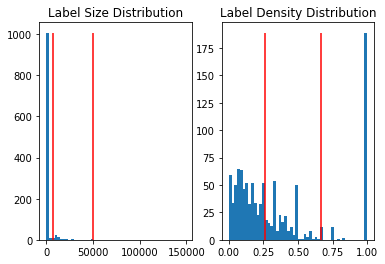

In [23]:
label_IDs = [id for id in np.unique(masks) if id != 0]
print(f'Identified {len(label_IDs)} labels')

print('Calculating point clouds...')
label_pcs = [return_points(masks, label_ID) for label_ID in tqdm(label_IDs)]

print('Calculating label sizes...')
label_sizes = [pc.shape[0] for pc in tqdm(label_pcs)]

print('Calculating point cloud densities...')
densities = [find_label_density(pc) for pc in tqdm(label_pcs)]

label_sizes = np.array(label_sizes).astype('float64')

low_size_thresh, high_size_thresh = threshold_multiotsu(label_sizes, 3)

densities = np.array(densities).astype('float64')

low_dense_thresh, high_dense_thresh = threshold_multiotsu(densities, 3)

# plot the sizes and densities:
fig, (ax1, ax2) = plt.subplots(1,2)
size_counts, _, _ = ax1.hist(label_sizes, bins=50)
ax1.vlines(low_size_thresh, 0, np.max(size_counts), color='r')
ax1.vlines(high_size_thresh, 0, np.max(size_counts), color='r')
ax1.set_title('Label Size Distribution')
dense_counts, _, _ = ax2.hist(densities, bins=50)
ax2.vlines(low_dense_thresh, 0, np.max(dense_counts), color='r')
ax2.vlines(high_dense_thresh, 0, np.max(dense_counts), color='r')
ax2.set_title('Label Density Distribution')
plt.show()

In [24]:
%gui qt 
viewer = napari.Viewer()

/Users/bementmbp/opt/anaconda3/envs/napari_apoc/lib/python3.9/site-packages/napari_tools_menu/__init__.py:168: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


In [25]:
viewer.add_labels(masks, name='masks', blending = 'additive')

print(f'removing objects smaller than {low_size_thresh}')
filtered_masks = morphology.remove_small_objects(masks, min_size=low_size_thresh, connectivity=1)

print(f'removing objects larger than {high_size_thresh}')
filtered_masks = remove_large_objects(filtered_masks, max_size=high_size_thresh)

print(f'removing objects with density smaller than {low_dense_thresh}')
remaining_labels = np.unique(filtered_masks)
for ind, id in enumerate(label_IDs):
    if all([id in remaining_labels,
            id != 0,
            densities[ind] < low_dense_thresh]):
        filtered_masks[filtered_masks == id] = 0

print(f'removing objects with density larger than {high_dense_thresh}')
for ind, id in enumerate(label_IDs):
    if all([id in remaining_labels,
            id != 0,
            densities[ind] > high_dense_thresh]):
        filtered_masks[filtered_masks == id] = 0

viewer.add_labels(filtered_masks, name='filtered', blending = 'additive')

Exception ignored in: <coroutine object get_msg at 0x7f9380a040c0>
Traceback (most recent call last):
  File "<string>", line 1, in <lambda>
KeyError: '__import__'
Exception ignored in: <coroutine object get_msg at 0x7f9380a040c0>
Traceback (most recent call last):
  File "<string>", line 1, in <lambda>
KeyError: '__import__'
Exception ignored in: <coroutine object get_msg at 0x7f9340fd72c0>
Traceback (most recent call last):
  File "<string>", line 1, in <lambda>
KeyError: '__import__'


removing objects smaller than 7227.85546875
removing objects larger than 50010.83984375
removing objects with density smaller than 0.2601652117071525
removing objects with density larger than 0.6661959134615385


<Labels layer 'filtered' at 0x7f9374a0a190>

might be worth just picking some size and density values to go with. 

# delete below if above works

In [ ]:
from skimage import filters
fig, ax = plt.subplots()
counts, _, _ = ax.hist(densities, bins=50)
# otsu threshold densities
low, high = threshold_multiotsu(np.asarray(densities))
print(f'low otsu threshold: {low}')
print(f'high otsu threshold: {high}')
ax.vlines(low, 0, np.max(counts), color='r', linestyle='--')
ax.vlines(high, 0, np.max(counts), color='r', linestyle='--')
plt.show()

In [ ]:
t = filters.threshold_otsu(np.asarray([1,2,3]))

In [ ]:
plt.hist(label_sizes, bins=50)
plt.show()

In [ ]:
t = np.asarray(densities)
thresh = filters.threshold_otsu(t)
thresh

#### Filter out all labels smaller than half the median size or larger than n times the median size:

In [ ]:
minimum_size = np.mean(label_volumes) / 2
maximum_size = np.mean(label_volumes) * 2
wipe_layers()
print(f'removing objects smaller than {minimum_size}')
filtered_masks = morphology.remove_small_objects(masks, min_size=minimum_size, connectivity=1)
print(f'removing objects larger than {maximum_size}')
filtered_masks = remove_large_objects(filtered_masks, max_size=maximum_size)
viewer.add_labels(filtered_masks, name='filtered_masks', blending='additive')

#### pick a "good" and "bad" label to play with:

In [ ]:
good_id = 129
bad_id = 20
good_points = np.column_stack(np.where(filtered_masks == good_id))
bad_points = np.column_stack(np.where(filtered_masks == bad_id))
print(f'collection of good points with shape {good_points.shape}')
print(f'collection of bad points with shape {bad_points.shape}')

In [ ]:
t = np.where(masks == 129)
t

method to identify size of 3D bounding box for a given label:

In [ ]:
good_points

In [ ]:
def find_label_density(arr: np.ndarray) -> float:
    '''
    Calculate the bounding box for a mask and return the number of points in the bounding box
    '''
    num_points = arr.shape[0]
    x = arr.T[0]
    y = arr.T[1]
    z = arr.T[2]
    x_min = np.min(x)
    x_max = np.max(x)
    y_min = np.min(y)
    y_max = np.max(y)
    z_min = np.min(z)
    z_max = np.max(z)
    x_range = x_max - x_min
    y_range = y_max - y_min
    z_range = z_max - z_min
    area = x_range * y_range * z_range
    density = num_points / area
    return density

good_d = find_label_density(good_points)
bad_d = find_label_density(bad_points)
print(f'good density: {good_d}')
print(f'bad density: {bad_d}')